<a href="https://colab.research.google.com/github/jothiovia-2004/project/blob/main/image_augumentation_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models

In [ ]:
def load_data():
  dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
  train_data = dataset['train']
  def preprocess(image, label):
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5
    return image
  train_data = train_data.map(preprocess).batch(64).shuffle(1000)
  return train_data
train_data = load_data()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def build_generator():
  model = models.Sequential()
  model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((8, 8, 256)))
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  return model

In [ ]:
def build_discriminator():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
def train_step(real_images):
  noise = tf.random.normal([real_images.shape[0], 100])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(real_images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def generate_and_display_images(model, epoch, test_input=None):
    if test_input is None:
        test_input = tf.random.normal([16, 100])  # Generate 16 random noise vectors
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2  # Rescale to [0, 1]
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.show()

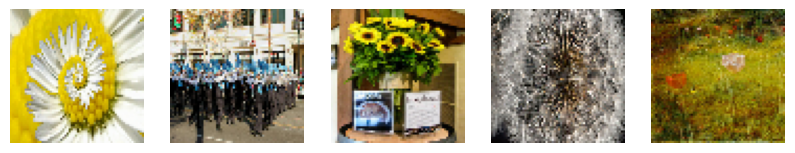

In [ ]:
def display_samples(dataset, num_samples=5):
    for images in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(num_samples):
            img = (images[i] + 1) / 2  # Rescale to [0, 1]
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()
display_samples(train_data)

Starting epoch 1
Epoch 1, Generator Loss: 1.6564915180206299, Discriminator Loss: 0.48974862694740295
Starting epoch 2
Epoch 2, Generator Loss: 2.493253231048584, Discriminator Loss: 0.25964492559432983
Starting epoch 3
Epoch 3, Generator Loss: 3.2111573219299316, Discriminator Loss: 0.0981234684586525
Starting epoch 4
Epoch 4, Generator Loss: 3.8453128337860107, Discriminator Loss: 0.07892563939094543
Starting epoch 5
Epoch 5, Generator Loss: 2.902439594268799, Discriminator Loss: 0.19732435047626495
Starting epoch 6
Epoch 6, Generator Loss: 3.9850919246673584, Discriminator Loss: 0.06702814996242523
Starting epoch 7
Epoch 7, Generator Loss: 2.861645221710205, Discriminator Loss: 0.091492660343647
Starting epoch 8
Epoch 8, Generator Loss: 4.490118980407715, Discriminator Loss: 0.23136986792087555
Starting epoch 9
Epoch 9, Generator Loss: 2.254093647003174, Discriminator Loss: 0.7410743236541748
Starting epoch 10
Epoch 10, Generator Loss: 3.736056327819824, Discriminator Loss: 0.303385

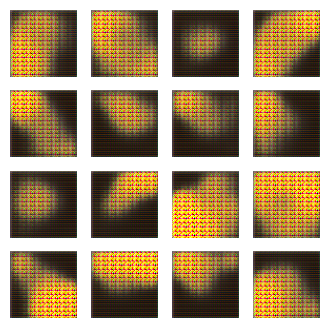

Starting epoch 11
Epoch 11, Generator Loss: 3.444295883178711, Discriminator Loss: 0.5096698999404907
Starting epoch 12
Epoch 12, Generator Loss: 3.9327099323272705, Discriminator Loss: 0.05458139255642891
Starting epoch 13
Epoch 13, Generator Loss: 2.9060754776000977, Discriminator Loss: 0.26244860887527466
Starting epoch 14
Epoch 14, Generator Loss: 4.202824115753174, Discriminator Loss: 0.2019650936126709
Starting epoch 15
Epoch 15, Generator Loss: 3.489419937133789, Discriminator Loss: 0.08953170478343964
Starting epoch 16
Epoch 16, Generator Loss: 3.8466625213623047, Discriminator Loss: 0.0793948769569397
Starting epoch 17
Epoch 17, Generator Loss: 3.485271453857422, Discriminator Loss: 0.5345479846000671
Starting epoch 18
Epoch 18, Generator Loss: 4.605956554412842, Discriminator Loss: 0.2739638090133667
Starting epoch 19
Epoch 19, Generator Loss: 8.14413070678711, Discriminator Loss: 0.12912403047084808
Starting epoch 20
Epoch 20, Generator Loss: 4.579328536987305, Discriminator

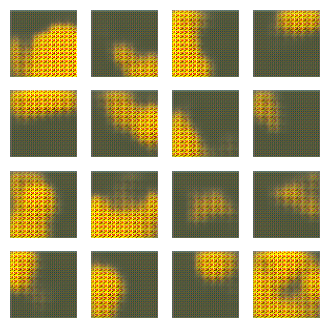

Starting epoch 21
Epoch 21, Generator Loss: 3.9357638359069824, Discriminator Loss: 0.06092644855380058
Starting epoch 22
Epoch 22, Generator Loss: 4.809925079345703, Discriminator Loss: 0.10340126603841782
Starting epoch 23
Epoch 23, Generator Loss: 4.705747604370117, Discriminator Loss: 0.287939190864563
Starting epoch 24
Epoch 24, Generator Loss: 4.072625160217285, Discriminator Loss: 0.13814222812652588
Starting epoch 25
Epoch 25, Generator Loss: 6.576513767242432, Discriminator Loss: 0.0821015015244484
Starting epoch 26
Epoch 26, Generator Loss: 5.865248680114746, Discriminator Loss: 0.08085433393716812
Starting epoch 27
Epoch 27, Generator Loss: 4.478348731994629, Discriminator Loss: 0.22315043210983276
Starting epoch 28
Epoch 28, Generator Loss: 5.661281585693359, Discriminator Loss: 0.0736330896615982
Starting epoch 29
Epoch 29, Generator Loss: 6.064413070678711, Discriminator Loss: 0.20588251948356628
Starting epoch 30
Epoch 30, Generator Loss: 5.121085166931152, Discriminator

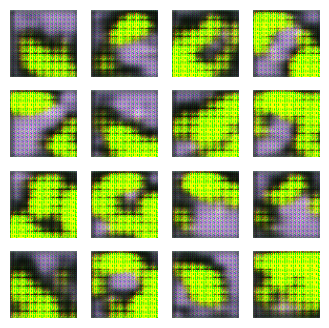

Starting epoch 31
Epoch 31, Generator Loss: 2.984224796295166, Discriminator Loss: 0.3669341802597046
Starting epoch 32
Epoch 32, Generator Loss: 3.9396793842315674, Discriminator Loss: 0.20282159745693207
Starting epoch 33
Epoch 33, Generator Loss: 3.7226462364196777, Discriminator Loss: 0.18396210670471191
Starting epoch 34
Epoch 34, Generator Loss: 3.483579635620117, Discriminator Loss: 0.1928407847881317
Starting epoch 35
Epoch 35, Generator Loss: 4.392376899719238, Discriminator Loss: 0.15354003012180328
Starting epoch 36
Epoch 36, Generator Loss: 3.892382860183716, Discriminator Loss: 0.22482353448867798
Starting epoch 37
Epoch 37, Generator Loss: 3.1147327423095703, Discriminator Loss: 0.36495441198349
Starting epoch 38
Epoch 38, Generator Loss: 3.467667579650879, Discriminator Loss: 0.49239015579223633
Starting epoch 39
Epoch 39, Generator Loss: 2.548552989959717, Discriminator Loss: 0.34470057487487793
Starting epoch 40
Epoch 40, Generator Loss: 3.4773077964782715, Discriminat

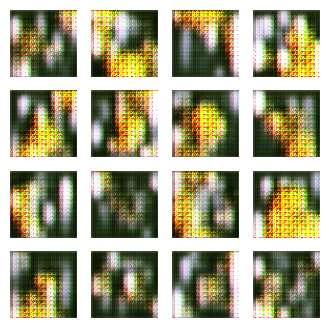

Starting epoch 41
Epoch 41, Generator Loss: 3.323164463043213, Discriminator Loss: 0.3484377861022949
Starting epoch 42
Epoch 42, Generator Loss: 4.193556785583496, Discriminator Loss: 0.2491416037082672
Starting epoch 43
Epoch 43, Generator Loss: 4.141987323760986, Discriminator Loss: 0.5072816610336304
Starting epoch 44
Epoch 44, Generator Loss: 2.7937917709350586, Discriminator Loss: 0.3692833483219147
Starting epoch 45
Epoch 45, Generator Loss: 2.2779901027679443, Discriminator Loss: 0.6391924023628235
Starting epoch 46
Epoch 46, Generator Loss: 6.283298492431641, Discriminator Loss: 0.18609412014484406
Starting epoch 47
Epoch 47, Generator Loss: 3.745723009109497, Discriminator Loss: 0.11518710851669312
Starting epoch 48
Epoch 48, Generator Loss: 2.9297146797180176, Discriminator Loss: 0.21993224322795868
Starting epoch 49
Epoch 49, Generator Loss: 3.3394720554351807, Discriminator Loss: 0.2033296674489975
Starting epoch 50
Epoch 50, Generator Loss: 2.8294434547424316, Discriminat

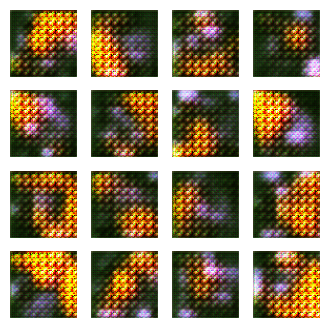

Starting epoch 51
Epoch 51, Generator Loss: 3.559373378753662, Discriminator Loss: 0.33014917373657227
Starting epoch 52
Epoch 52, Generator Loss: 3.2502551078796387, Discriminator Loss: 0.45253604650497437
Starting epoch 53
Epoch 53, Generator Loss: 4.396596908569336, Discriminator Loss: 0.3356498181819916
Starting epoch 54
Epoch 54, Generator Loss: 2.517148017883301, Discriminator Loss: 0.8783360719680786
Starting epoch 55
Epoch 55, Generator Loss: 3.13033127784729, Discriminator Loss: 0.4263588786125183
Starting epoch 56
Epoch 56, Generator Loss: 3.5505762100219727, Discriminator Loss: 0.33899402618408203
Starting epoch 57
Epoch 57, Generator Loss: 2.369318962097168, Discriminator Loss: 0.5836704969406128
Starting epoch 58
Epoch 58, Generator Loss: 2.6172633171081543, Discriminator Loss: 0.47471296787261963
Starting epoch 59
Epoch 59, Generator Loss: 2.546248435974121, Discriminator Loss: 0.40701979398727417
Starting epoch 60
Epoch 60, Generator Loss: 3.488917827606201, Discriminato

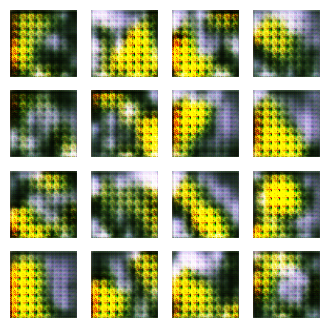

Starting epoch 61
Epoch 61, Generator Loss: 2.82790470123291, Discriminator Loss: 0.5513650178909302
Starting epoch 62
Epoch 62, Generator Loss: 3.3711280822753906, Discriminator Loss: 0.48043879866600037
Starting epoch 63
Epoch 63, Generator Loss: 3.654188871383667, Discriminator Loss: 0.13472875952720642
Starting epoch 64
Epoch 64, Generator Loss: 3.4070324897766113, Discriminator Loss: 0.3353361487388611
Starting epoch 65
Epoch 65, Generator Loss: 3.64313006401062, Discriminator Loss: 0.4329991936683655
Starting epoch 66
Epoch 66, Generator Loss: 3.3955302238464355, Discriminator Loss: 0.46353378891944885
Starting epoch 67
Epoch 67, Generator Loss: 3.9300119876861572, Discriminator Loss: 0.3965616226196289
Starting epoch 68
Epoch 68, Generator Loss: 2.9551234245300293, Discriminator Loss: 0.1730440855026245
Starting epoch 69
Epoch 69, Generator Loss: 3.5001332759857178, Discriminator Loss: 0.163496196269989
Starting epoch 70
Epoch 70, Generator Loss: 3.7414212226867676, Discriminato

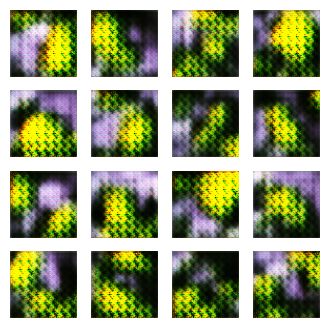

Starting epoch 71
Epoch 71, Generator Loss: 5.434967041015625, Discriminator Loss: 0.3094402253627777
Starting epoch 72
Epoch 72, Generator Loss: 3.191437244415283, Discriminator Loss: 0.30092576146125793
Starting epoch 73
Epoch 73, Generator Loss: 3.132934093475342, Discriminator Loss: 0.1506531834602356
Starting epoch 74
Epoch 74, Generator Loss: 2.558459758758545, Discriminator Loss: 0.8603693842887878
Starting epoch 75
Epoch 75, Generator Loss: 2.7950193881988525, Discriminator Loss: 0.19910328090190887
Starting epoch 76
Epoch 76, Generator Loss: 3.1171092987060547, Discriminator Loss: 0.45176973938941956
Starting epoch 77
Epoch 77, Generator Loss: 2.150203227996826, Discriminator Loss: 0.7724262475967407
Starting epoch 78
Epoch 78, Generator Loss: 2.505183219909668, Discriminator Loss: 0.5472570061683655
Starting epoch 79
Epoch 79, Generator Loss: 2.4041805267333984, Discriminator Loss: 0.6778756976127625
Starting epoch 80
Epoch 80, Generator Loss: 2.8417201042175293, Discriminato

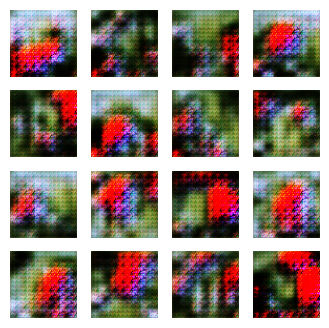

Starting epoch 81
Epoch 81, Generator Loss: 3.000608205795288, Discriminator Loss: 0.4185943603515625
Starting epoch 82
Epoch 82, Generator Loss: 2.555691719055176, Discriminator Loss: 0.4801254868507385
Starting epoch 83
Epoch 83, Generator Loss: 2.364179849624634, Discriminator Loss: 0.3419363796710968
Starting epoch 84
Epoch 84, Generator Loss: 2.429497241973877, Discriminator Loss: 0.2901111841201782
Starting epoch 85
Epoch 85, Generator Loss: 3.015442371368408, Discriminator Loss: 0.6224075555801392
Starting epoch 86
Epoch 86, Generator Loss: 2.6095328330993652, Discriminator Loss: 1.1356713771820068
Starting epoch 87
Epoch 87, Generator Loss: 3.9129881858825684, Discriminator Loss: 0.58244788646698
Starting epoch 88
Epoch 88, Generator Loss: 3.6872873306274414, Discriminator Loss: 0.32691508531570435
Starting epoch 89
Epoch 89, Generator Loss: 2.3478147983551025, Discriminator Loss: 0.5324758291244507
Starting epoch 90
Epoch 90, Generator Loss: 1.9732906818389893, Discriminator L

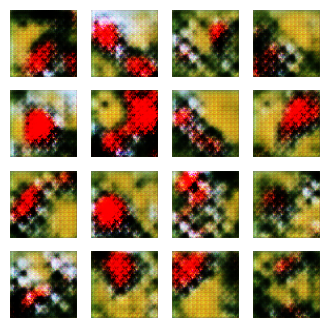

Starting epoch 91
Epoch 91, Generator Loss: 2.6664092540740967, Discriminator Loss: 0.4419551491737366
Starting epoch 92
Epoch 92, Generator Loss: 2.1124792098999023, Discriminator Loss: 0.6100220680236816
Starting epoch 93
Epoch 93, Generator Loss: 1.5305852890014648, Discriminator Loss: 0.6651275157928467
Starting epoch 94
Epoch 94, Generator Loss: 2.2545671463012695, Discriminator Loss: 0.4142899811267853
Starting epoch 95
Epoch 95, Generator Loss: 2.955707311630249, Discriminator Loss: 0.7034593224525452
Starting epoch 96
Epoch 96, Generator Loss: 2.089370012283325, Discriminator Loss: 0.7728627324104309
Starting epoch 97
Epoch 97, Generator Loss: 2.847102403640747, Discriminator Loss: 0.26853686571121216
Starting epoch 98
Epoch 98, Generator Loss: 2.876906156539917, Discriminator Loss: 0.3446156084537506
Starting epoch 99
Epoch 99, Generator Loss: 2.8753411769866943, Discriminator Loss: 0.3341837525367737
Starting epoch 100
Epoch 100, Generator Loss: 2.4602346420288086, Discrimina

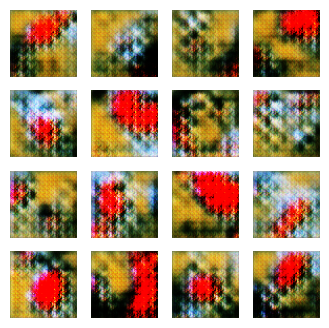

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Starting epoch {epoch + 1}")
        for real_images in dataset:
            gen_loss, disc_loss = train_step(real_images)
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")
        if (epoch + 1) % 10 == 0:
            generate_and_display_images(generator, epoch)
train(train_data, epochs=100)